In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import matplotlib.pyplot as plt
plt.figure
import plotly.express as px 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 6
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import plot_predict
from sklearn import metrics

## Data Preprocessing 

In [4]:
df=pd.read_csv('/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv') #loading the dataset
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [5]:
df.isnull().sum() #checking for null values

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

In [6]:
# I have observed the presence of missing values, 
# so i have dropped the values. 
df = df.dropna()

In [7]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


In [8]:
df.shape

(8235082, 7)

In [9]:
df['month'] =  pd.to_datetime(df['dt']).dt.month
df.head() #extracting month from date for each recording

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,11
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,4
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,5
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,6
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,7


In [12]:
#Deriving season attribute based on month
def get_season(month):
    if month>=3 and month<=5:
        return 'spring'
    elif month>=6 and month<=8:
        return 'summer'
    elif month>=9 and month<=11:
        return 'autumn'
    else:
        return 'winter' 

In [13]:

df['season'] = df['month'].apply(get_season)
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,season
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,11,autumn
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,4,spring
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,5,spring
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,6,summer
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,7,summer


In [14]:
# Assuming date_column is the name of your date column
df['year'] = pd.to_datetime(df['dt']).dt.year

# Get unique years
unique_years = df['year'].unique()
print(unique_years)

[1743 1744 1745 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760
 1761 1762 1763 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774
 1775 1776 1777 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788
 1789 1790 1791 1792 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802
 1803 1804 1805 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816
 1817 1818 1819 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830
 1831 1832 1833 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844
 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858
 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872
 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886
 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900
 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914
 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928
 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942
 1943 

In [15]:
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
month                            0
season                           0
year                             0
dtype: int64

In [16]:
df.shape 

(8235082, 10)

In [17]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,season,year
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,11,autumn,1743
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,4,spring,1744
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,5,spring,1744
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,6,summer,1744
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,7,summer,1744


In [18]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty,month,year
count,8.235082e+06,8.235082e+06,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00,6.493786e+00,1.910834e+03
std,1.035344e+01,1.129733e+00,3.451505e+00,6.419609e+01
min,-4.270400e+01,3.400000e-02,1.000000e+00,1.743000e+03
25%,1.029900e+01,3.370000e-01,3.000000e+00,1.865000e+03
50%,1.883100e+01,5.910000e-01,6.000000e+00,1.915000e+03
75%,2.521000e+01,1.349000e+00,9.000000e+00,1.964000e+03
max,3.965100e+01,1.539600e+01,1.200000e+01,2.013000e+03


In [19]:
Country_counts = df['Country'].value_counts()
print(Country_counts)

Country
India               960548
China               819132
United States       661524
Brazil              451645
Russia              448663
                     ...  
Burundi               1675
Eritrea               1669
Djibouti              1658
Oman                  1652
Papua New Guinea      1580
Name: count, Length: 159, dtype: int64


In [20]:
India = df[df['Country']=='India']
city_counts = []
city_counts = India['City'].value_counts()
print(city_counts) #number of cities in India from the dataset. 


City
Kanchrapara     2532
Barakpur        2532
Chandannagar    2532
Champdani       2532
Basirhat        2532
                ... 
Ludhiana        2075
Firozpur        2075
Moga            2075
Shimla          2065
Chandigarh      2065
Name: count, Length: 391, dtype: int64


In [21]:
usa = df[df['Country']=='United States']
city_counts = []
city_counts = usa['City'].value_counts()
print(city_counts)




City
Springfield       9147
Columbus          6238
Aurora            5474
Arlington         5444
Peoria            5280
                  ... 
San Diego         1977
San Bernardino    1977
Salinas           1977
Berkeley          1977
Oxnard            1977
Name: count, Length: 248, dtype: int64


In [23]:
is_chicago = 'Chicago' in usa['City'].values

if is_chicago:
    print("Chicago is in the 'city' column.")
else:
    print("Chicago is not in the 'city' column.")

Chicago is in the 'city' column.


In [24]:
city=['Chicago']
Chicago_data=usa[usa['City'].isin(city)]
Chicago_data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,season,year
1543348,1743-11-01,5.436,2.205,Chicago,United States,42.59N,87.27W,11,autumn,1743
1543353,1744-04-01,8.766,2.357,Chicago,United States,42.59N,87.27W,4,spring,1744
1543354,1744-05-01,11.605,2.102,Chicago,United States,42.59N,87.27W,5,spring,1744
1543355,1744-06-01,17.965,1.989,Chicago,United States,42.59N,87.27W,6,summer,1744
1543356,1744-07-01,21.680,1.786,Chicago,United States,42.59N,87.27W,7,summer,1744
...,...,...,...,...,...,...,...,...,...,...
1546582,2013-05-01,13.734,0.863,Chicago,United States,42.59N,87.27W,5,spring,2013
1546583,2013-06-01,17.913,0.669,Chicago,United States,42.59N,87.27W,6,summer,2013
1546584,2013-07-01,21.914,0.322,Chicago,United States,42.59N,87.27W,7,summer,2013
1546585,2013-08-01,22.230,0.373,Chicago,United States,42.59N,87.27W,8,summer,2013


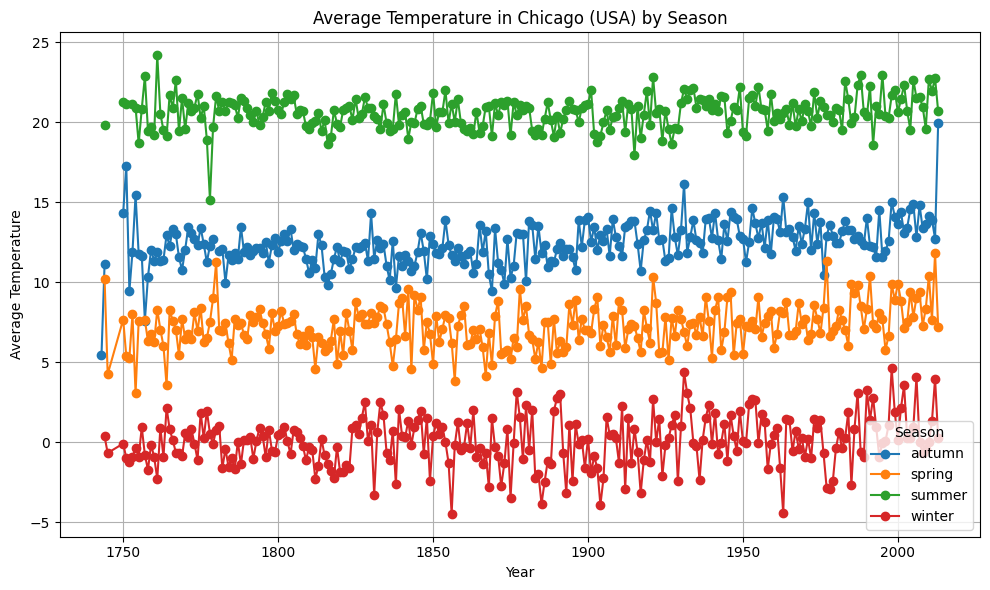

In [25]:

# Calculate average temperature for each season and year
seasonal_avg_temp = Chicago_data.groupby(['year', 'season'])['AverageTemperature'].mean().unstack()

# Plotting
plt.figure(figsize=(10, 6))
seasonal_avg_temp.plot(marker='o', linestyle='-', ax=plt.gca())
plt.xlabel('Year')
plt.ylabel('Average Temperature')
plt.title('Average Temperature in Chicago (USA) by Season')
plt.legend(title='Season', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
data2 = Chicago_data

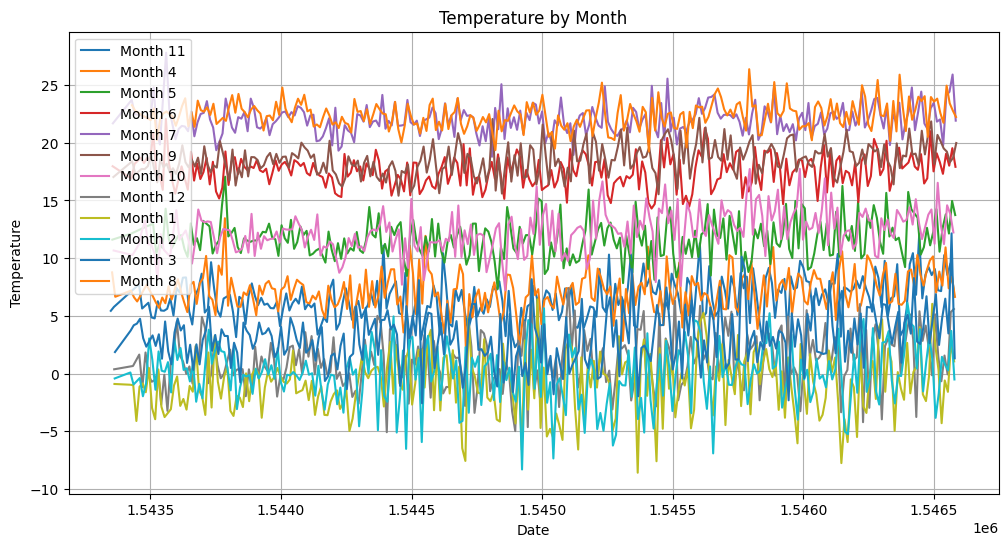

In [27]:
months = data2['month'].unique()
plt.figure(figsize=(12, 6))
for month in months:
    plt.plot(data2[data2['month'] == month].index, data2[data2['month'] == month]['AverageTemperature'], label=f'Month {month}')
plt.title('Temperature by Month')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

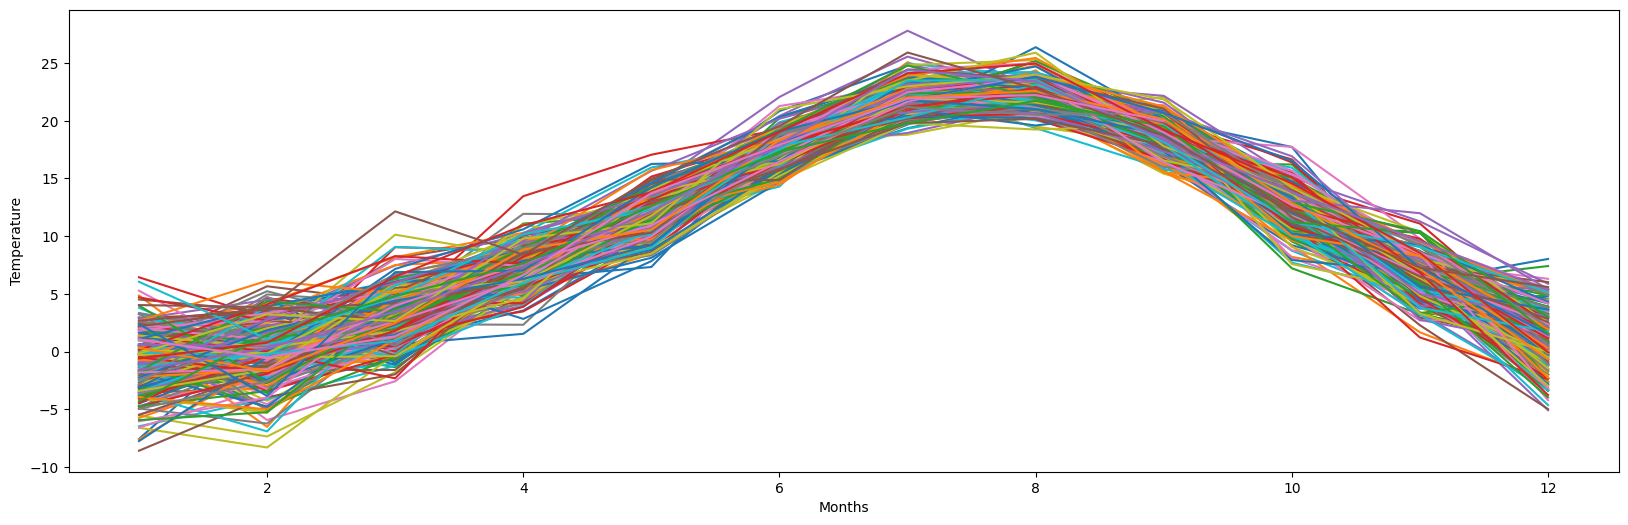

In [28]:
pivot = data2.pivot(index='month', columns='year', values='AverageTemperature')

pivot.plot(figsize=(20, 6))
plt.legend().remove()
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.show()

In [29]:
data2 = Chicago_data

In [33]:
data2 = Chicago_data
data2=data2[['dt','AverageTemperature']]
data2.columns=['Date','Temp']
data2.head()
df2 = data2

In [34]:
data2.columns=['Date','Temp']
data2.head()
df2 = data2

In [35]:
print(data2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 1543348 to 1546586
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3141 non-null   object 
 1   Temp    3141 non-null   float64
dtypes: float64(1), object(1)
memory usage: 73.6+ KB
None


In [36]:
data2.shape

(3141, 2)

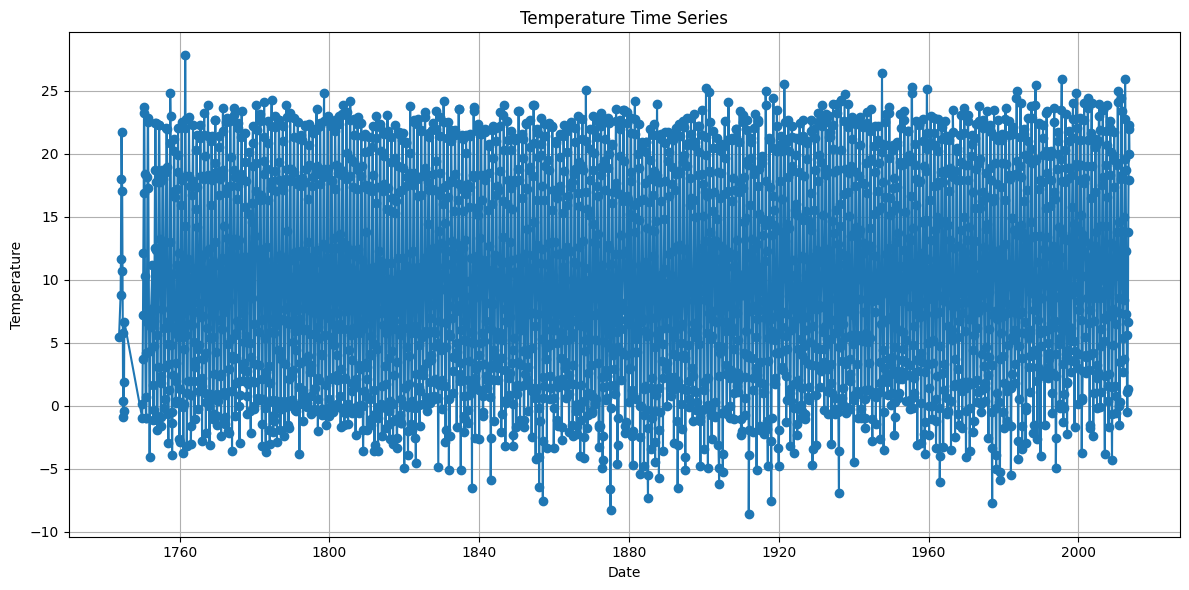

In [37]:
# Convert 'Date' column to datetime format
data2['Date'] = pd.to_datetime(data2['Date'])

# Set 'Date' column as index
data2.set_index('Date', inplace=True)

# Plot the temperature data
plt.figure(figsize=(12, 6))
plt.plot(data2.index, data2['Temp'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Time Series')
plt.grid(True)
plt.tight_layout()
plt.show()

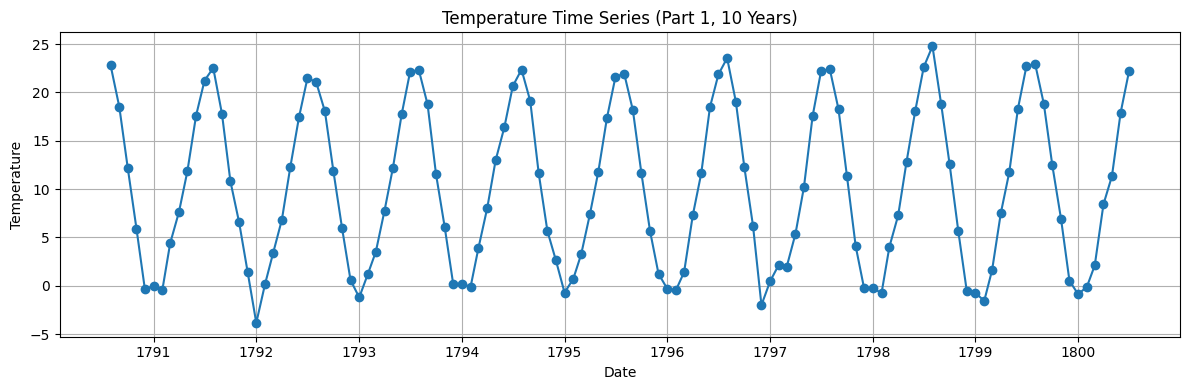

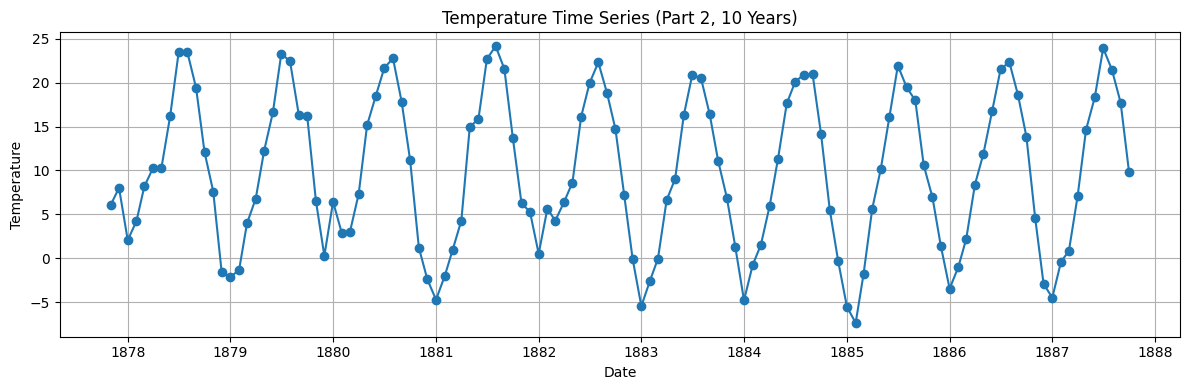

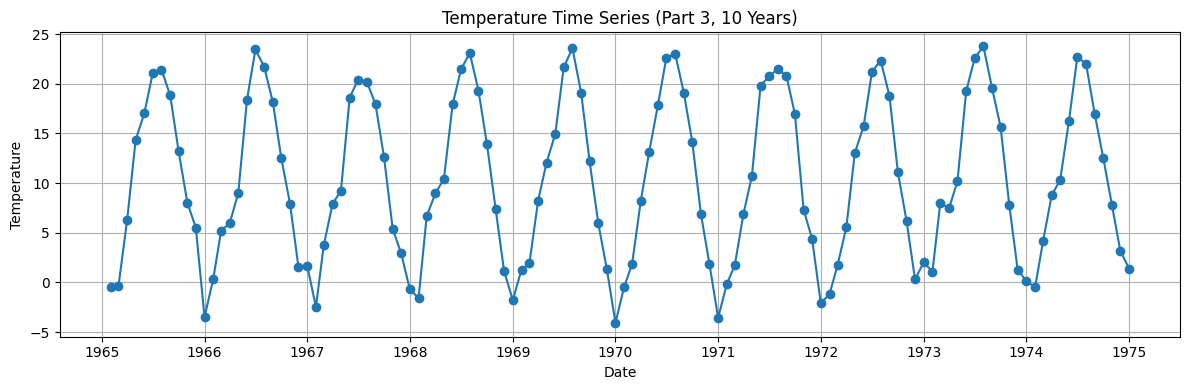

In [46]:
# Convert 'Date' column to datetime format
#data2 = df2
data2['Date'] = pd.to_datetime(data2['Date'])

# Set 'Date' column as index
data2.set_index('Date', inplace=True)
#since the Data consists of more than 3000 observations, we have splitted the data into 3 parts to have better observation for trend & seasonality. 
# Split the data into three parts
num_obs = len(data2)
part_size = num_obs // 3

# Plot 10 years of data from each part
for i in range(3):
    start_idx = i * part_size
    end_idx = start_idx + part_size if i < 2 else num_obs
    subset_start_idx = start_idx + (end_idx - start_idx - 10 * 12) // 2
    subset_end_idx = subset_start_idx + 10 * 12
    plt.figure(figsize=(12, 4))
    plt.plot(data2.index[subset_start_idx:subset_end_idx], data2['Temp'][subset_start_idx:subset_end_idx], marker='o', linestyle='-')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.title(f'Temperature Time Series (Part {i+1}, 10 Years)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**Decomposition [Trend, Seasonality, Residual]**

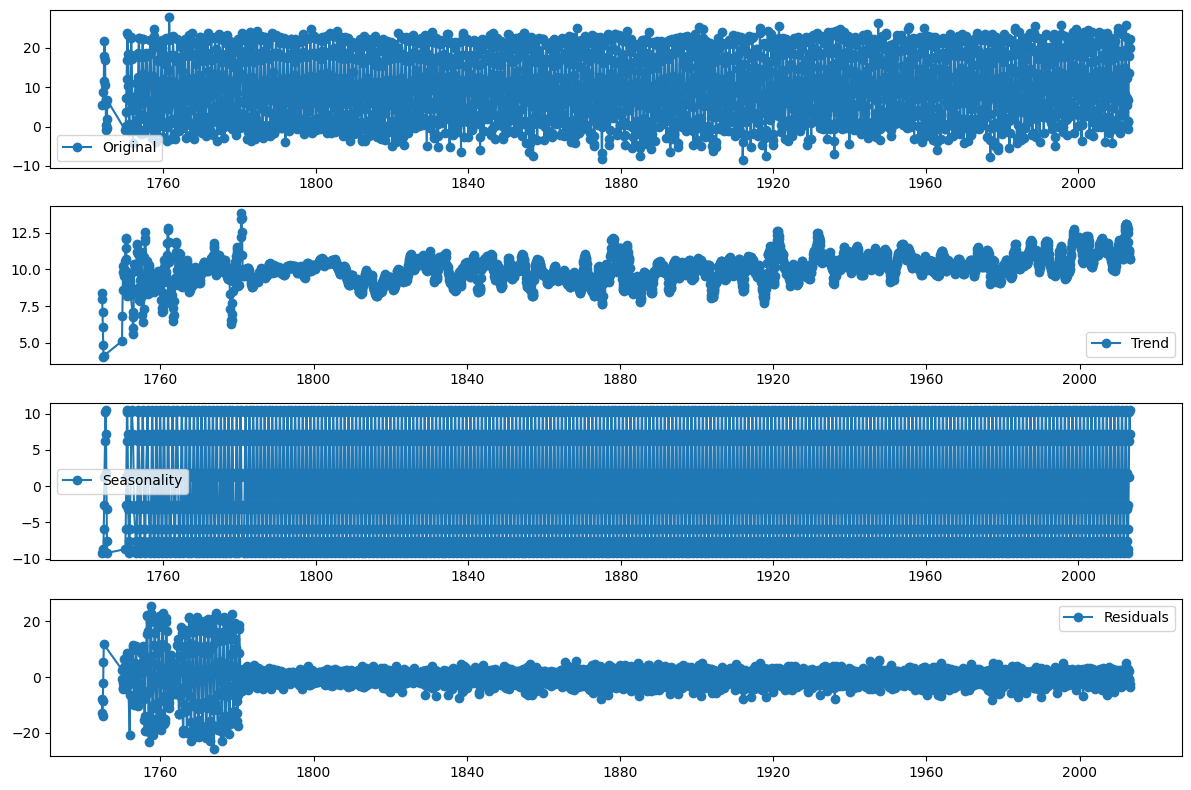

In [47]:
# Decompose the time series to check for trend and seasonality
decomposition = seasonal_decompose(data2['Temp'], period=12)  # Assuming a seasonal period of 12 months
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data2.index, data2['Temp'], label='Original', marker='o', linestyle='-')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(data2.index, trend, label='Trend', marker='o', linestyle='-')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(data2.index, seasonal, label='Seasonality', marker='o', linestyle='-')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(data2.index, residual, label='Residuals', marker='o', linestyle='-')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## **Stationary check**

In [48]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(data2['Temp'])

In [49]:
def adfuller_test(temp):
    result=adfuller(temp)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [50]:
adfuller_test(data2['Temp'])

ADF Test Statistic : -6.136682572298648
p-value : 8.155104183672214e-08
#Lags Used : 28
Number of Observations Used : 3112
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [51]:
data2.head()

,Temp
Date,
1743-11-01,5.436
1744-04-01,8.766
1744-05-01,11.605
1744-06-01,17.965
1744-07-01,21.680


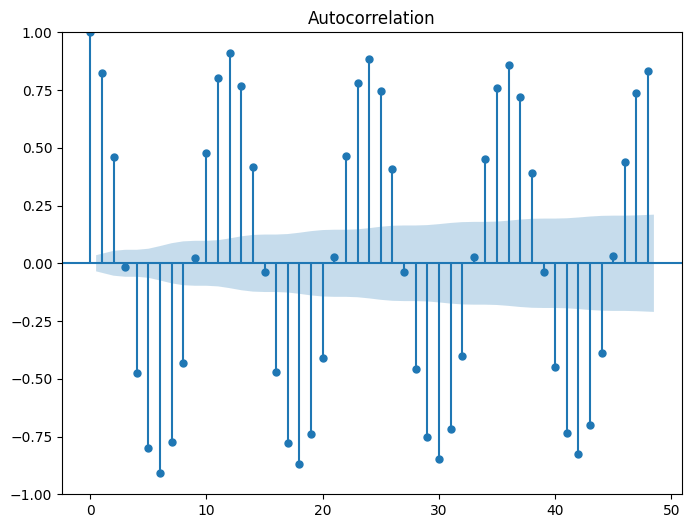

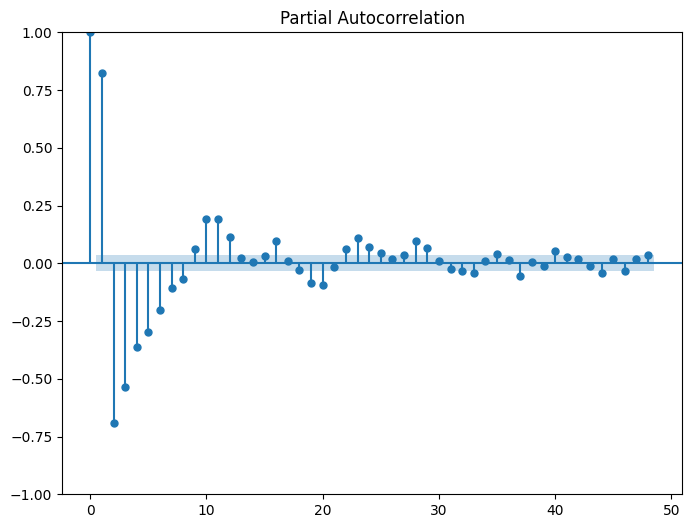

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming your stationary data is stored in the df dataframe
# Plot ACF
plot_acf(data2['Temp'], lags=48)
plt.show()

# Plot PACF
plot_pacf(data2['Temp'], lags=48)
plt.show()

## **ARIMA**

In [43]:
data2 = Chicago_data
data2=data2[['dt','AverageTemperature']]
data2.columns=['Date','Temp']
data2.head()
df2 = data2

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import numpy as np


# Convert Date to datetime format
data2['Date'] = pd.to_datetime(data2['Date'])

# Grid search for best pdq values
best_aic = float("inf")
best_pdq = None
top_10_aic = [(float("inf"), None)] * 10

for p, d, q in product(range(0, 3), range(0, 3), range(0, 4)):
    try:
        model = ARIMA(data2['Temp'], order=(p, d, q))
        model_fit = model.fit()
        aic = model_fit.aic

        # Update the top 10 AIC scores
        top_10_aic.append((aic, (p, d, q)))
        top_10_aic.sort(key=lambda x: x[0])
        top_10_aic = top_10_aic[:10]

        # Update the best AIC and PDQ values
        if aic < best_aic:
            best_aic = aic
            best_pdq = (p, d, q)
    except:
        continue

print("Top 10 combinations of parameters with the best AIC scores:")
for i, (aic, pdq) in enumerate(top_10_aic):
    print(f"{i+1}. AIC: {aic}, PDQ: {pdq}")

print(f"Best PDQ values: {best_pdq}")

# Train best model
arima_model = ARIMA(data2['Temp'], order=best_pdq)
arima_model_fit = arima_model.fit()


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be 

Top 10 combinations of parameters with the best AIC scores:
1. AIC: 14503.18796408741, PDQ: (2, 0, 3)
2. AIC: 14549.612198621595, PDQ: (2, 1, 3)
3. AIC: 14668.077459489316, PDQ: (2, 0, 2)
4. AIC: 14946.046733142935, PDQ: (2, 1, 2)
5. AIC: 15082.753426534904, PDQ: (2, 2, 3)
6. AIC: 15094.653432092233, PDQ: (2, 0, 1)
7. AIC: 16665.6416619096, PDQ: (2, 0, 0)
8. AIC: 17271.91124640028, PDQ: (1, 0, 2)
9. AIC: 17446.374980492343, PDQ: (0, 0, 3)
10. AIC: 17598.680010663913, PDQ: (1, 1, 3)
Best PDQ values: (2, 0, 3)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

# Assuming your data is stored in the data2 dataframe
# Convert Date to datetime format
data2['Date'] = pd.to_datetime(data2['Date'])

# Grid search for best pdq values
best_aic = float("inf")
best_pdq = None
for p, d, q in product(range(0, 5), range(0, 5), range(0, 4)):
    try:
        model = ARIMA(data2['Temp'], order=(p, d, q))
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_pdq = (p, d, q)
    except:
        continue

print(f"Best PDQ values: {best_pdq}")

# Train best models
arima_model = ARIMA(data2['Temp'], order=best_pdq)
arima_model_fit = arima_model.fit()




/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be 

Best PDQ values: (2, 0, 3)


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



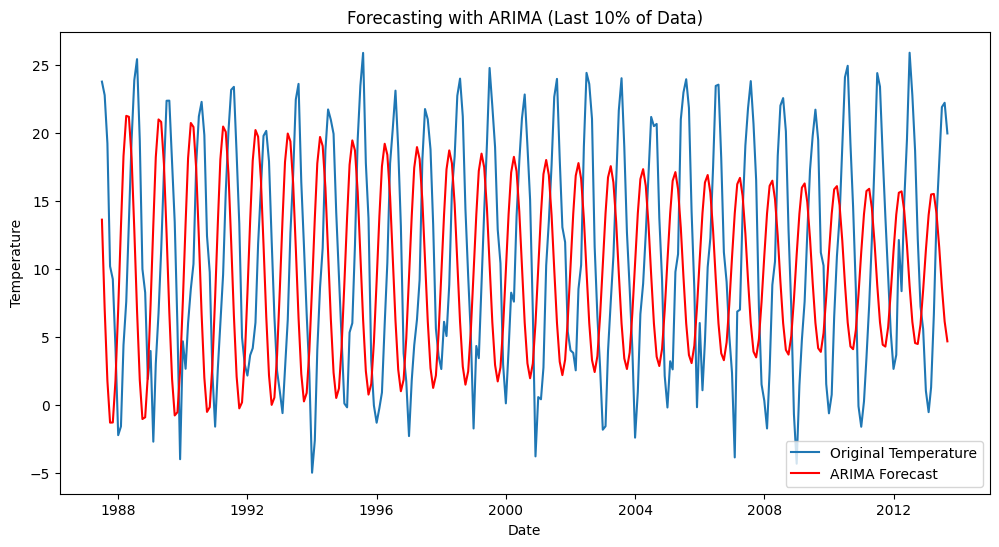

Mean Absolute Error: nan


In [57]:
# Determine the index at which the last 10% of the data starts
last_10_percent_index = int(len(data2) * 0.9)

# Forecast next 10% from the last 10% of the data
forecast_arima = arima_model_fit.forecast(steps=len(data2) - last_10_percent_index)

# Plotting
plt.figure(figsize=(12, 6))

# Plot last 10% of the original data with the forecasted values
plt.plot(data2['Date'].iloc[last_10_percent_index:], data2['Temp'].iloc[last_10_percent_index:], label='Original Temperature')
plt.plot(data2['Date'].iloc[last_10_percent_index:], forecast_arima, label='ARIMA Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Forecasting with ARIMA (Last 10% of Data)')
plt.legend()
plt.show()

# Calculate the error between forecasted and original values
error = forecast_arima - data2['Temp'].iloc[last_10_percent_index:]
print(f'Mean Absolute Error: {error.abs().mean()}')


In [58]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate MSE
mse = mean_squared_error(data2['Temp'].iloc[last_10_percent_index:], forecast_arima)

# Calculate RMSE
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Squared Error (MSE): 123.55887699308796
Root Mean Squared Error (RMSE): 11.115704070956907


/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



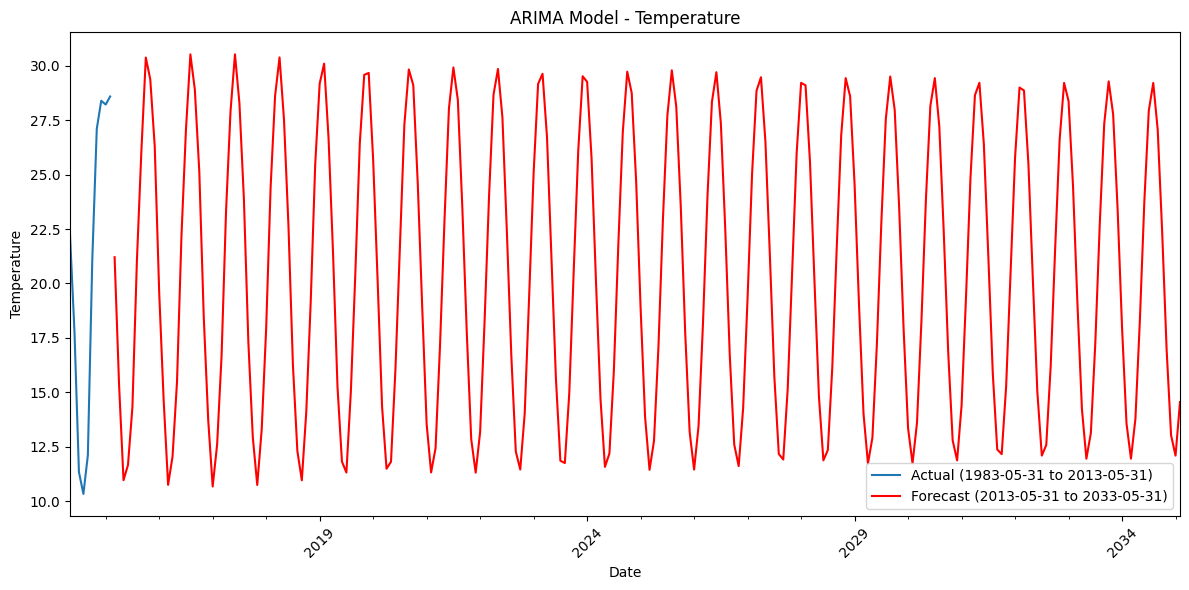

In [65]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Define the dataframe with the next 20 years of dates
data2 = pd.DataFrame({'Temp': [22.216101, 17.76611, 11.33812, 10.33711, 12.1132, 21.14642, 27.10052, 28.3926, 28.2177, 28.5888]},
                      index=pd.date_range('2014-05-31', periods=10, freq='M'))

# Fit an ARIMA model to the data
model = ARIMA(data2['Temp'], order=(3, 0, 5))
fit_model = model.fit()

# Generate forecasts for the next 20 years (240 months)
forecast_steps = 240
forecast = fit_model.forecast(steps=forecast_steps)

# Plot the forecast along with the previous 30 years of data
plt.figure(figsize=(12, 6))
data2['Temp'].plot(label='Actual (1983-05-31 to 2013-05-31)')
forecast.plot(color='red', label='Forecast (2013-05-31 to 2033-05-31)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('ARIMA Model - Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


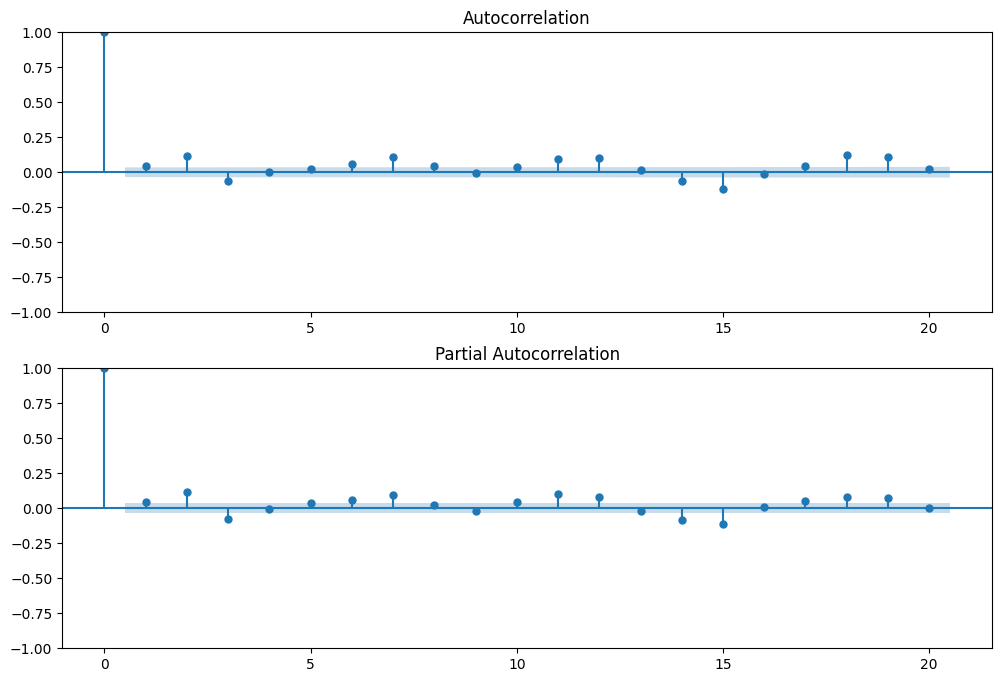

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Residuals of the ARIMA model
residuals = arima_model_fit.resid

# Plot ACF and PACF of residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=20, ax=ax1, alpha=0.05)
plot_pacf(residuals, lags=20, ax=ax2, alpha=0.05)
plt.show()


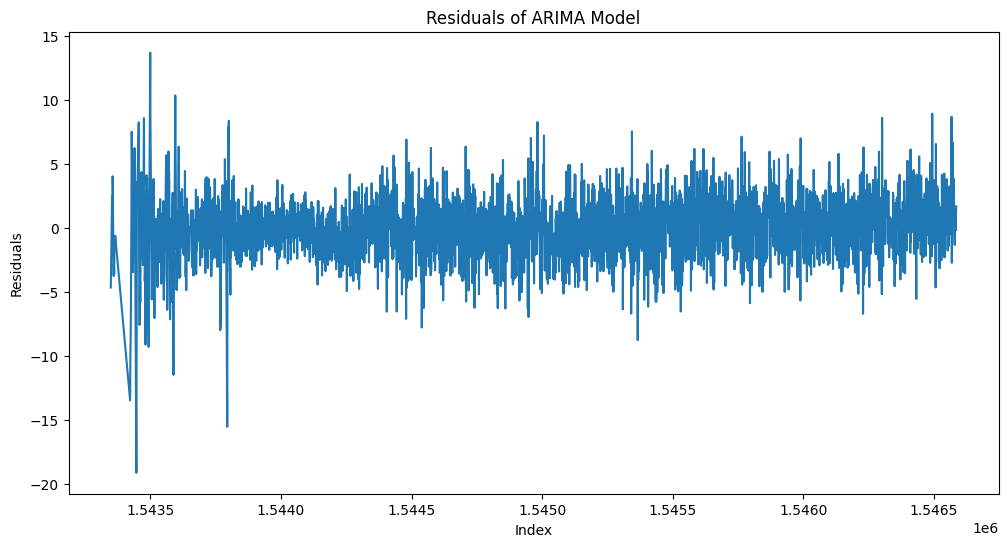

In [60]:
plt.figure(figsize=(12, 6))
plt.plot(residuals)
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.title('Residuals of ARIMA Model')
plt.show()

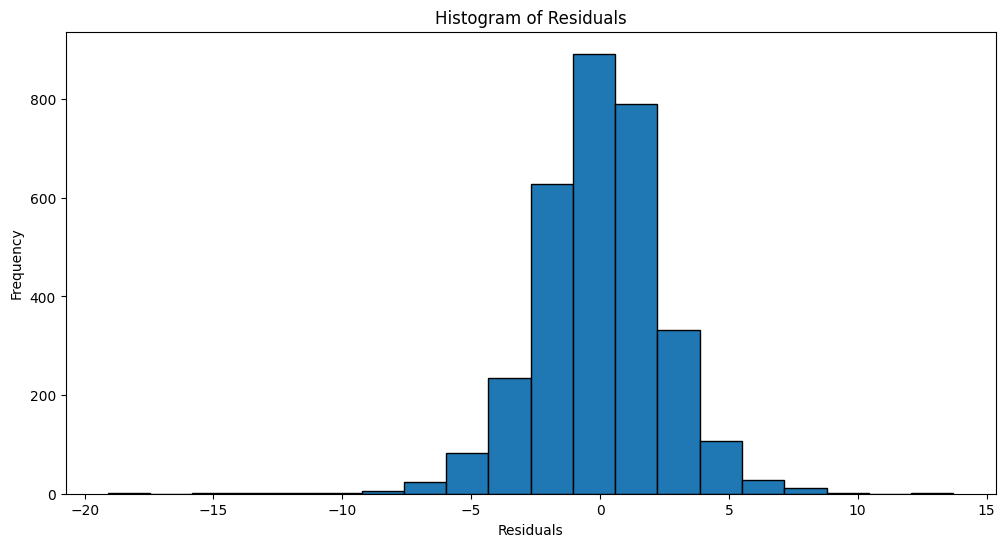

In [61]:
# Plot histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()


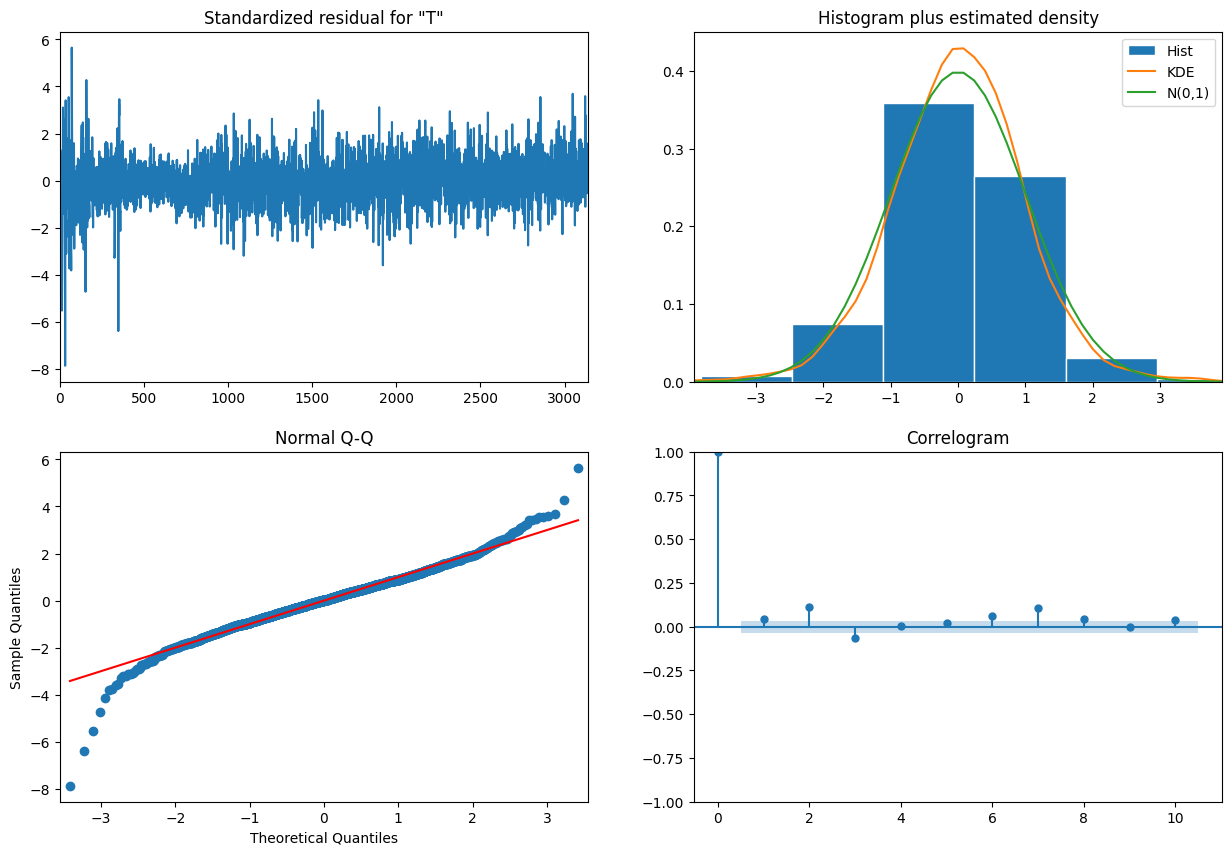

In [61]:
# Plot diagnostics
arima_model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()


In [67]:
data2 = Chicago_data
data2=data2[['dt','AverageTemperature']]
data2.columns=['Date','Temp']
data2.head()
df2 = data2

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74890D+00    |proj g|=  3.32900D-01


 This problem is unconstrained.



At iterate    5    f=  2.44051D+00    |proj g|=  8.71343D-02

At iterate   10    f=  2.40736D+00    |proj g|=  1.05209D-02

At iterate   15    f=  2.40624D+00    |proj g|=  1.44643D-02

At iterate   20    f=  2.40500D+00    |proj g|=  2.11325D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     28      1     0     0   7.736D-06   2.405D+00
  F =   2.4049994574237643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



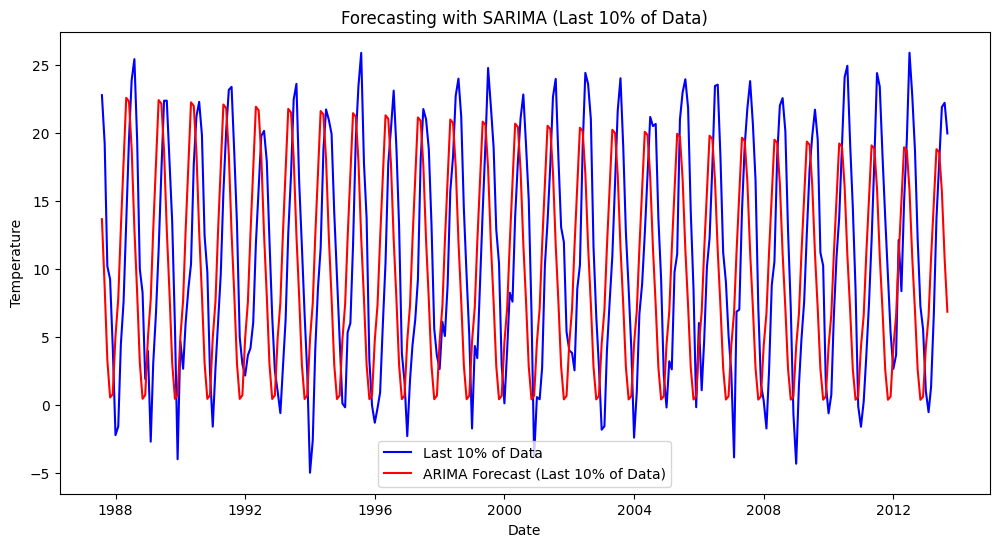

MSE: 62.86065016036172
RMSE: 7.928470858895914


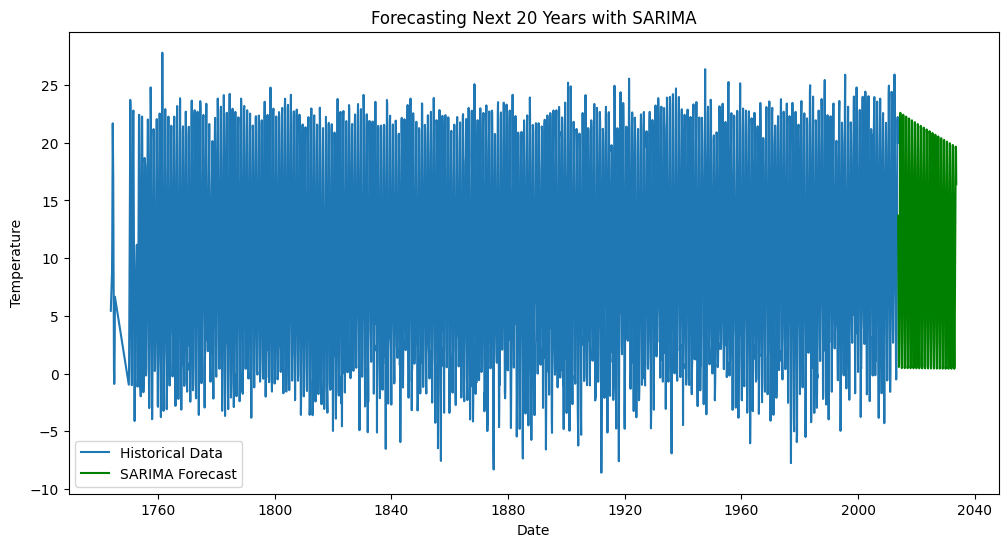

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Convert Date to datetime format
data2['Date'] = pd.to_datetime(data2['Date'])

# Train SARIMA model
sarima_model = SARIMAX(data2['Temp'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_model_fit = sarima_model.fit()

# Forecast next 20 years from the last date in the dataset
forecast_sarima = sarima_model_fit.forecast(steps=20 * 12)

# Plotting
plt.figure(figsize=(12, 6))

# Plot last 10% of the data
last_10_percent = int(len(data2) * 0.1)
plt.plot(data2['Date'][-last_10_percent:], data2['Temp'][-last_10_percent:], label='Last 10% of Data', color='blue')

# Plot ARIMA forecast for the last 10% of the data
forecast_arima_last_10_percent = sarima_model_fit.get_forecast(steps=last_10_percent)
forecast_arima_last_10_percent_mean = forecast_arima_last_10_percent.predicted_mean
plt.plot(data2['Date'][-last_10_percent:], forecast_arima_last_10_percent_mean, label='ARIMA Forecast (Last 10% of Data)', color='red')

plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Forecasting with SARIMA (Last 10% of Data)')
plt.legend()
plt.show()

# Calculate MSE and RMSE
actual_values = data2['Temp'][-last_10_percent:]
mse = mean_squared_error(actual_values, forecast_arima_last_10_percent_mean)
rmse = np.sqrt(mse)
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

# Plot next 20 years forecast along with previous 30 years of data
plt.figure(figsize=(12, 6))
plt.plot(data2['Date'], data2['Temp'], label='Historical Data')
plt.plot(pd.date_range(start=data2['Date'].iloc[-1] + pd.DateOffset(days=1), periods=20*12, freq='M'), forecast_sarima, label='SARIMA Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Forecasting Next 20 Years with SARIMA')
plt.legend()
plt.show()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87780D+00    |proj g|=  1.21656D+01

At iterate    5    f=  3.01617D+00    |proj g|=  1.15745D-01


 This problem is unconstrained.



At iterate   10    f=  2.76820D+00    |proj g|=  6.18463D-02

At iterate   15    f=  2.69713D+00    |proj g|=  4.38503D-02

At iterate   20    f=  2.66411D+00    |proj g|=  3.16870D-02

At iterate   25    f=  2.65882D+00    |proj g|=  4.06671D-02

At iterate   30    f=  2.65585D+00    |proj g|=  5.60823D-03

At iterate   35    f=  2.65429D+00    |proj g|=  6.03428D-02

At iterate   40    f=  2.65303D+00    |proj g|=  5.66331D-02

At iterate   45    f=  2.65222D+00    |proj g|=  6.68936D-02

At iterate   50    f=  2.65198D+00    |proj g|=  1.70112D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     67   

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



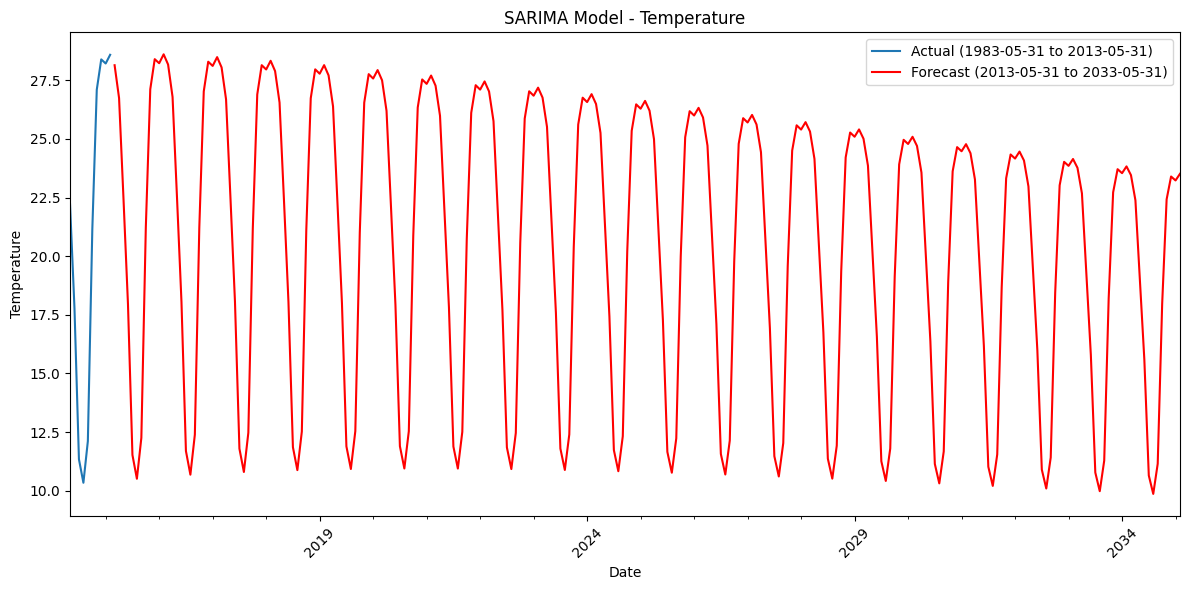

In [40]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define the dataframe with the next 20 years of dates
data2 = pd.DataFrame({'Temp': [22.216101, 17.76611, 11.33812, 10.33711, 12.1132, 21.14642, 27.10052, 28.3926, 28.2177, 28.5888]},
                      index=pd.date_range('2014-05-31', periods=10, freq='M'))

# Fit a SARIMA model to the data
model = SARIMAX(data2['Temp'], order=(3, 0, 5), seasonal_order=(1, 0, 1, 12))
fit_model = model.fit()

# Generate forecasts for the next 20 years (240 months)
forecast_steps = 240
forecast = fit_model.forecast(steps=forecast_steps)

# Plot the forecast along with the previous 30 years of data
plt.figure(figsize=(12, 6))
data2['Temp'].plot(label='Actual (1983-05-31 to 2013-05-31)')
forecast.plot(color='red', label='Forecast (2013-05-31 to 2033-05-31)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('SARIMA Model - Temperature')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


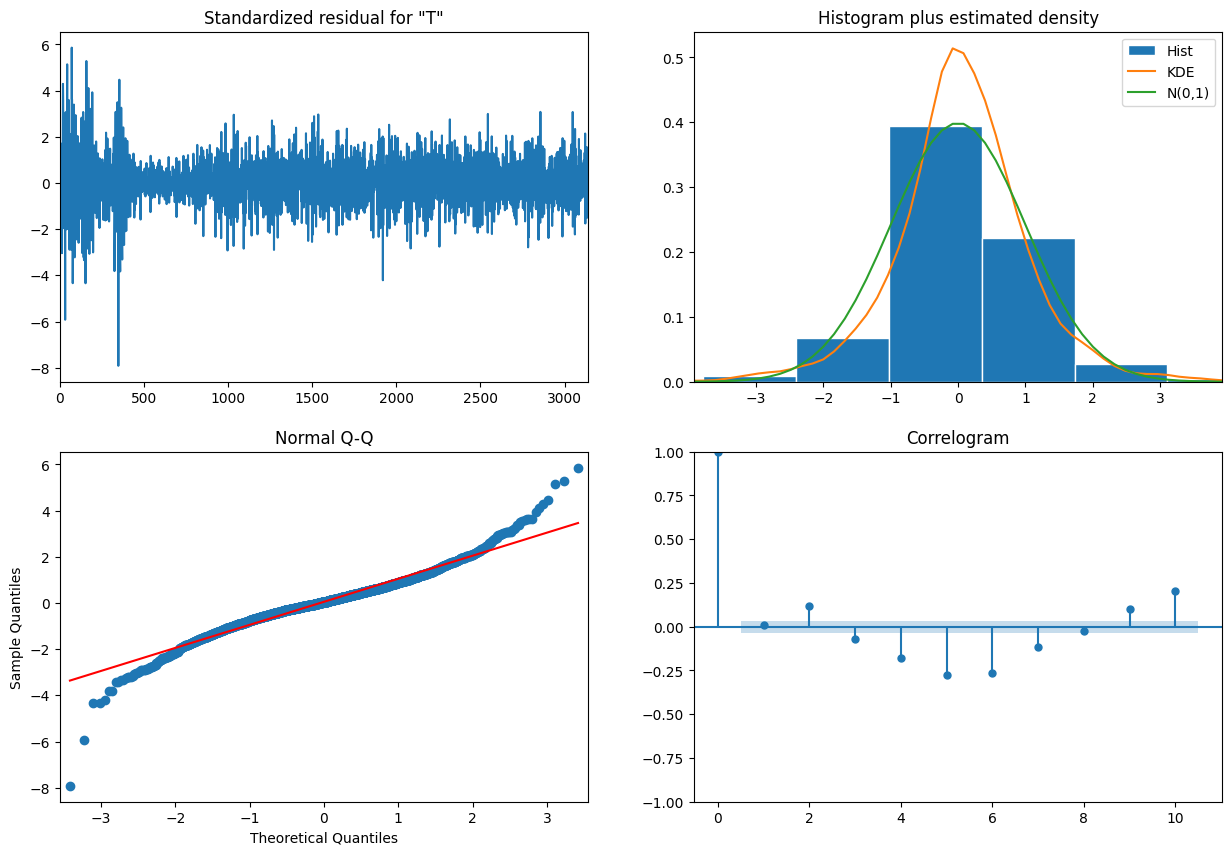

In [72]:
# Plot diagnostics
sarima_model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

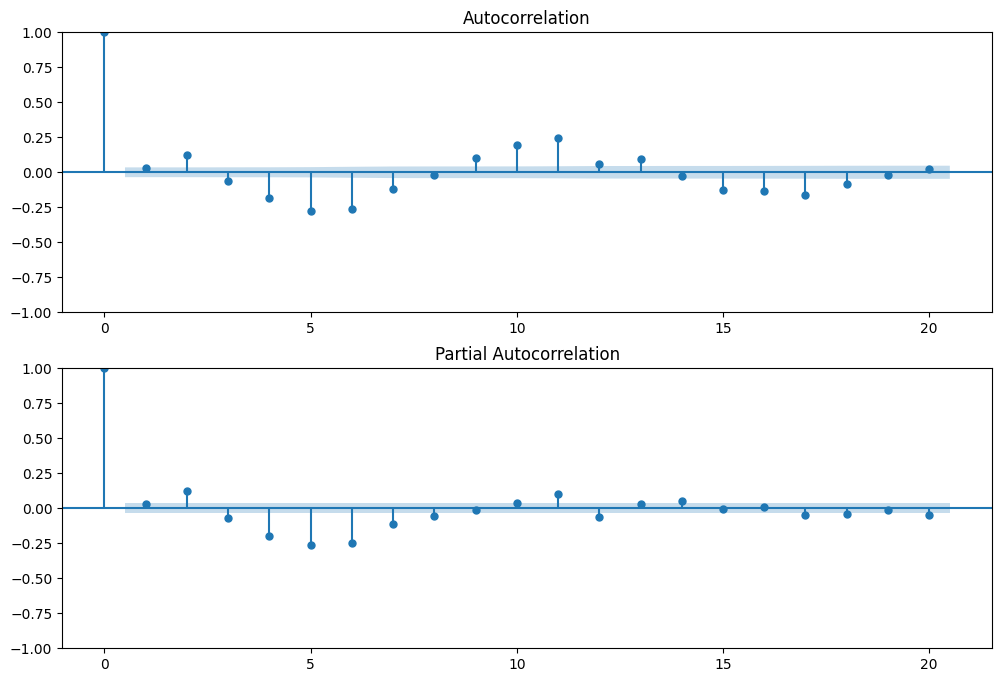

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Residuals of the ARIMA model
residuals = sarima_model_fit.resid

# Plot ACF and PACF of residuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=20, ax=ax1, alpha=0.05)
plot_pacf(residuals, lags=20, ax=ax2, alpha=0.05)
plt.show()
